# UTD data processing & SI/AI generation

In [23]:
import os
import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [24]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


### Load data

In [25]:
# Function for generating standard type of signal data
def get_signal(file_names):
    
    out_list = []
    
    for file_name in file_names:
        
        raw_data = pd.read_csv(path + file_name)
        
        if len(raw_data) < 128:
            continue
        
        subject = re.match(r'a.*?(?=_t)',file_name).group()[-1]
        activity = re.match(r'a.*?(?=_s)',file_name).group()[1:]
        remove_subject = ['22', '23', '24', '25', '26', '27']
        
        # Ignore the activity from 22 to 27
        if activity in remove_subject:
            continue
            
        else:
            acc_x = np.array(raw_data['0'])[:128]
            acc_y = np.array(raw_data['1'])[:128]
            acc_z = np.array(raw_data['2'])[:128]
            gyro_x = np.array(raw_data['3'])[:128]
            gyro_y = np.array(raw_data['4'])[:128]
            gyro_z = np.array(raw_data['5'])[:128]


        temp_array = np.array([subject, acc_x, acc_y, acc_z, gyro_x, gyro_y, gyro_z, activity],dtype=object)
        out_list.append(temp_array)
    
    return out_list
    

In [26]:
# Get all file names of sensor data
path = './UTD-Data/UTD/csv/'
file_names = os.listdir(path)

col_label = ['Subject', 'acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z','Activity']

# Extract the activities from 1 to 21
sig_data = get_signal(file_names)
sig_data_df = pd.DataFrame(sig_data, columns=col_label)


In [27]:
len(sig_data_df)

649

In [28]:
sig_data_df.head()

,Subject,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,Activity
0,1,"[-0.9516600000000001, -0.948486, -0.9404299999...","[-0.41626, -0.425537, -0.426025, -0.507568, -0...","[-0.09106399999999999, -0.118652, -0.140869, -...","[-18.198473, -18.717557, -21.40458, -23.389313...","[-8.671756, -7.847328, -5.679389, -2.229008000...","[8.610686999999999, 6.442748, 2.22900800000000...",10
1,1,"[-0.959717, -0.964355, -0.976807, -0.980713, -...","[-0.33129899999999995, -0.343018, -0.370117000...","[-0.11108399999999999, -0.126953, -0.140381, -...","[6.564885, 10.80916, 12.091603, 8.152672, 5.28...","[0.335878, 1.7404580000000003, 3.541985, 7.725...","[-2.80916, -3.603053, -6.10687, -9.679389, -14...",10
2,1,"[-0.954834, -0.9628909999999999, -0.962158, -0...","[-0.43335, -0.480469, -0.5014649999999999, -0....","[-0.223877, -0.280273, -0.32055700000000004, -...","[5.648855, 6.564885, 2.167939, 1.557252, 5.526...","[12.274809, 16.0, 20.702289999999998, 27.14503...","[-13.19084, -16.763359, -18.59542, -24.824427,...",10
3,1,"[-0.938232, -0.9472659999999999, -0.935059, -0...","[-0.321533, -0.32959, -0.31738299999999997, -0...","[-0.190674, -0.190186, -0.19653299999999999, -...","[-1.89313, -1.3435110000000001, -1.435115, 0.0...","[-0.396947, 0.274809, 0.8549620000000001, 1.43...","[-1.5877860000000001, -1.770992, -1.679389, -1...",10
4,2,"[-0.976318, -0.981934, -0.9855959999999999, -0...","[-0.185059, -0.18676800000000002, -0.187256, -...","[0.304199, 0.305664, 0.302246, 0.3044429999999...","[-1.7404580000000003, -1.770992, -1.770992, -1...","[1.3435110000000001, 1.282443, 1.251908, 1.374...","[-0.70229, -0.70229, -0.641221, -0.580153, -0....",10


In [29]:
# Split the data set into train & test set
from sklearn.model_selection import train_test_split

train_UTD, test_UTD = train_test_split(sig_data_df, test_size=0.2, random_state=42)

train_UTD_feature = train_UTD.drop(['Subject','Activity'], axis=1)
train_UTD_label = train_UTD['Activity']

test_UTD_feature = test_UTD.drop(['Subject','Activity'], axis=1)
test_UTD_label = test_UTD['Activity']

In [30]:
train_UTD.head()

,Subject,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,Activity
332,6,"[-1.005615, -1.009033, -0.999023, -1.004883, -...","[-0.11181600000000001, -0.12329100000000001, -...","[0.057861, 0.052979, 0.05127, 0.050049, 0.0295...","[1.282443, 0.122137, -1.5877860000000001, -2.8...","[0.824427, 0.7938930000000001, 0.4580149999999...","[-0.45801499999999995, -0.671756, -1.099237, -...",1
29,8,"[-0.9897459999999999, -0.980957, -0.979736, -0...","[-0.185547, -0.17724600000000001, -0.182861, -...","[0.128906, 0.12133800000000002, 0.114501999999...","[-4.549618, -3.8778629999999996, -4.152672, -3...","[2.625954, 0.305344, -0.396947, 0.427481000000...","[-2.3511450000000003, -2.412214, -1.007634, 1....",10
302,6,"[-1.009521, -1.036377, -1.041504, -1.040039, -...","[-0.1604, -0.16406300000000001, -0.23290999999...","[0.042236, 0.037108999999999996, -0.021484, -0...","[-1.221374, -7.541985, -9.740458, -14.412214, ...","[-0.48855, -0.763359, -1.099237, -2.5038169999...","[-1.770992, -1.679389, -1.7099240000000002, -3...",19
286,2,"[-1.0314940000000001, -1.105225, -1.169189, -1...","[-0.45629899999999995, -0.607178, -0.753174, -...","[0.462158, 0.38623, 0.297852, 0.201172, 0.1567...","[-55.603053, -82.900763, -100.427481, -108.091...","[6.717557000000001, 11.419847, 23.022901, 41.1...","[-4.580153, -7.6335880000000005, -25.709923999...",19
554,8,"[-1.011475, -1.0310059999999999, -1.027588, -1...","[-0.23901399999999998, -0.238281, -0.212891, -...","[0.029053, 0.007324, 0.0271, 0.063965, -0.0427...","[-0.671756, -4.061069, 0.244275, 16.152672, 27...","[-1.40458, 0.244275, 3.6335879999999996, 5.984...","[0.9160309999999999, -0.42748100000000006, -1....",6


In [31]:
atrain_less_128 = [{36: 127}, {55: 127}, {56: 125}, {68: 109}, {70: 123}, {91: 107}, {143: 126}, {204: 114}, {233: 127}, {305: 125}, {308: 118}, {315: 112}, {326: 122}, {352: 114}, {391: 125}, {408: 124}, {466: 127}, {483: 125}, {493: 122}, {525: 125}]
atest_less_128 = [{22: 127}, {87: 125}]

### Jiang & Yin's method

In [32]:
def alg_2(raw_signal): ### input:raw signal list (6xNumber of sample point)
    Ns = len(raw_signal)
    sis = []
    signal_images = []
    for i in range(1,Ns+1):
        sis.append(i)
        signal_images.append(raw_signal[i-1])
    i = Ns
    j = i + 1
    Nsis = len(sis)
    while (i != j):
        inter_sis = list(zip(sis, sis[1:] + sis[:0]))
        if j > (Ns):
            j = 1
        elif (i,j) not in inter_sis and (j,i) not in inter_sis:
            sis.append(j)
            signal_images.append(raw_signal[j-1])
            Nsis += 1
            i = j
            j = i + 1
        else:
            j = j+1
    print("SIS:",sis,"NSIS:",Nsis,"(i,j):",(i,j))
    return signal_images

### New Method

In [33]:
# Algoritnm for Signal data arrangement
def order_SI(raw_sig):
    
    # The raw should be a [n,sensor_type] size array
    
    # According to the number of the types of sensor data
    # Generate a list of all possible pairs of each two sensor data
    type_sensor = raw_sig.shape[1]
    pair_list = []
    
    for i in range (1,type_sensor):
        temp_list = []
        temp_list = [temp_list+[i,j+1] for j in range(i,type_sensor)]
        pair_list += temp_list
        
    # After getting all possible pairs
    # Complete the sig_list that ensure each two sensor datas are adjacent at least once
    
    # The idea is to initial the sig_list as [1,2], 
    # Then combine other possible pairs at both ends of the sig_list according to the same number
    # The priority of the combination is from long list(e.g., [1,x]) to short list(e.g., [5,x]) in pair_list
    
    # Initial the sig_list to store the arrange of each input signal vectors
    sig_list = pair_list[0]
    del pair_list[0]
    
    # Run the process until no element in pair_list
    while pair_list:
        
        for pair in pair_list:
               
            if sig_list[0] == pair[0]:
                sig_list.insert(0,pair[1])
                pair_list.remove(pair)
                break
                

            elif sig_list[0] == pair[1]:
                sig_list.insert(0,pair[0])
                pair_list.remove(pair)
                break
                

            elif sig_list[-1] == pair[0]:
                sig_list.append(pair[1])
                pair_list.remove(pair)
                break
                

            elif sig_list[-1] == pair[1]:
                sig_list.append(pair[0])
                pair_list.remove(pair)
                break
                
                
            elif pair == pair_list[-1]:
                sig_list.append(pair[0])
                sig_list.append(pair[1])
                pair_list.remove(pair)
                break
    
    
    left_sig_list = []
    right_sig_list = []

    left_sig_list.append(sig_list[1])
    for i in range(len(sig_list)-1):
        left_sig_list.append(sig_list[i])

    right_sig_list.append(sig_list[1])
    for i in range(len(sig_list)-2):
        right_sig_list.append(sig_list[i+2])
    right_sig_list.append(sig_list[0])

    return sig_list,left_sig_list,right_sig_list

#     # Initial a list to store reconstructed raw data
#     sig_img = []
#     for sig_order in sig_list:
#         sig_img.append(raw_sig[sig_order-1])
    
#     return sig_list, left_sig_list, right_sig_list



In [34]:
# temp_array = np.array([1,2,3,4,5,6]).reshape(1,-1)
# middle_list, left_list, right_list = order_SI(temp_array)
# print(left_list)
# print(middle_list)
# print(right_list)

In [35]:
temp_array = np.array([1,2,3,4,5,6]).reshape(1,-1)
mid_list, left_list, right_list = order_SI(temp_array)
mid_list, left_list, right_list

([1, 6, 2, 5, 1, 4, 2, 3, 1, 2, 5, 6, 3, 4, 5, 3, 4, 6],
 [6, 1, 6, 2, 5, 1, 4, 2, 3, 1, 2, 5, 6, 3, 4, 5, 3, 4],
 [6, 2, 5, 1, 4, 2, 3, 1, 2, 5, 6, 3, 4, 5, 3, 4, 6, 1])

### Generate Signal Image & activity image

In [36]:
# Split the data set into train & test set
from sklearn.model_selection import train_test_split

train_UTD, test_UTD = train_test_split(sig_data_df, test_size=0.2, random_state=42)

train_UTD_feature = np.array(train_UTD.drop(['Subject','Activity'], axis=1))
train_UTD_label = np.array(train_UTD['Activity'])

test_UTD_feature = np.array(test_UTD.drop(['Subject','Activity'], axis=1))
test_UTD_label = np.array(test_UTD['Activity'])

In [37]:
train_UTD_label.shape

(519,)

In [38]:
mid_list, left_list, right_list = order_SI(train_UTD_feature)
mid_list, left_list, right_list

([1, 6, 2, 5, 1, 4, 2, 3, 1, 2, 5, 6, 3, 4, 5, 3, 4, 6],
 [6, 1, 6, 2, 5, 1, 4, 2, 3, 1, 2, 5, 6, 3, 4, 5, 3, 4],
 [6, 2, 5, 1, 4, 2, 3, 1, 2, 5, 6, 3, 4, 5, 3, 4, 6, 1])

In [39]:
# Generate SI & AI 3d array

# Initial an empty 3d array
L_train_feature_128 = np.empty(shape = (len(train_UTD_feature), len(left_list), 128))
M_train_feature_128 = np.empty(shape = (len(train_UTD_feature), len(mid_list), 128))
R_train_feature_128 = np.empty(shape = (len(train_UTD_feature), len(right_list), 128))

L_test_feature_128 = np.empty(shape = (len(test_UTD_feature), len(left_list), 128))
M_test_feature_128 = np.empty(shape = (len(test_UTD_feature), len(mid_list), 128))
R_test_feature_128 = np.empty(shape = (len(test_UTD_feature), len(right_list), 128))

Multi_train_feature_128 = np.empty(shape = (len(train_UTD_feature), len(mid_list), 128*3))
Multi_test_feature_128 = np.empty(shape = (len(test_UTD_feature), len(mid_list), 128*3))

for i in range(len(train_UTD_feature)):
    
    temp_L = np.vstack([np.stack(train_UTD_feature[i])[np.array(sig_order)-1] for sig_order in left_list])
    temp_M = np.vstack([np.stack(train_UTD_feature[i])[np.array(sig_order)-1] for sig_order in left_list])
    temp_R = np.vstack([np.stack(train_UTD_feature[i])[np.array(sig_order)-1] for sig_order in right_list])
    
    L_train_feature_128[i, :, :] = temp_L
    M_train_feature_128[i, :, :] = temp_M
    R_train_feature_128[i, :, :] = temp_R
    
    Multi_train_feature_128[i, :, :] = np.hstack((temp_L,temp_M,temp_R))
    

for i in range(len(test_UTD_feature)):
    
    temp_L = np.vstack([np.stack(test_UTD_feature[i])[np.array(sig_order)-1] for sig_order in left_list])
    temp_M = np.vstack([np.stack(test_UTD_feature[i])[np.array(sig_order)-1] for sig_order in left_list])
    temp_R = np.vstack([np.stack(test_UTD_feature[i])[np.array(sig_order)-1] for sig_order in right_list])
    
    L_test_feature_128[i, :, :] = temp_L
    M_test_feature_128[i, :, :] = temp_M
    R_test_feature_128[i, :, :] = temp_R
    
    Multi_test_feature_128[i, :, :] = np.hstack((temp_L,temp_M,temp_R))


In [40]:
Multi_train_feature_128.shape, Multi_test_feature_128.shape

((519, 18, 384), (130, 18, 384))

In [41]:
L_train_feature_128.shape, M_train_feature_128.shape, R_train_feature_128.shape

((519, 18, 128), (519, 18, 128), (519, 18, 128))

In [42]:
L_test_feature_128.shape, M_test_feature_128.shape, R_test_feature_128.shape

((130, 18, 128), (130, 18, 128), (130, 18, 128))

In [43]:
a = np.array([[1,2,3],[4,5,6]])
b = np.array([[1,1,1],[2,2,2]])
c = np.array([[7,7,7],[8,8,8]])
temp = np.hstack((a,b,c))
temp

array([[1, 2, 3, 1, 1, 1, 7, 7, 7],
       [4, 5, 6, 2, 2, 2, 8, 8, 8]])

In [44]:
a.shape

(2, 3)

In [51]:
# For fixed over lapping
olp_rate = 0.5

# Take window size 64
w_size_128 = 128
w_size_64 = 64
w_size_32 = 32

sample_num_128 = int((128*3-w_size_128)/(w_size_128*olp_rate) + 1)
sample_num_64 = int((128*3-w_size_64)/(w_size_64*olp_rate) + 1)
sample_num_32 = int((128*3-w_size_32)/(w_size_32*olp_rate) + 1)

# Initial empty 3d array
Multi_train_feature_128_true = np.empty(shape = (len(Multi_train_feature_128)*sample_num_128, len(mid_list), 128))
Multi_test_feature_128_true = np.empty(shape = (len(Multi_test_feature_128)*sample_num_128, len(mid_list), 128))

Multi_train_feature_64 = np.empty(shape = (len(Multi_train_feature_128)*sample_num_64, len(mid_list), 64))
Multi_test_feature_64 = np.empty(shape = (len(Multi_test_feature_128)*sample_num_64, len(mid_list), 64))

Multi_train_feature_32 = np.empty(shape = (len(Multi_train_feature_128)*sample_num_32, len(mid_list), 32))
Multi_test_feature_32 = np.empty(shape = (len(Multi_test_feature_128)*sample_num_32, len(mid_list), 32))


In [52]:
sample_num_128,sample_num_64,sample_num_32

(5, 11, 23)

In [53]:
Multi_train_feature_64.shape, Multi_test_feature_64.shape, Multi_train_feature_32.shape, Multi_test_feature_32.shape

((5709, 18, 64), (1430, 18, 64), (11937, 18, 32), (2990, 18, 32))

In [54]:
Multi_train_feature_128_true.shape, Multi_test_feature_128_true.shape

((2595, 18, 128), (650, 18, 128))

## Fill with the readings
## For 128 window size

In [55]:
# Train_128

count = 0

# Feature
for i in range(len(Multi_train_feature_128)):
    
    index_start = 0
    
    for j in range(sample_num_128):
        
        index_end = index_start + 128
        
        Multi_train_feature_128_true[count, :, :] = Multi_train_feature_128[i][:, index_start:index_end]
        
        count += 1
        
        index_start += 64
        
# Label
Multi_train_128_label_true = np.array([train_UTD_label[0]]*sample_num_128)

for n in range(1,len(train_UTD_label)):
    temp_label = np.array([train_UTD_label[n]]*sample_num_128)
    Multi_train_128_label_true = np.append(Multi_train_128_label_true, temp_label)


In [56]:
# Test_128

count = 0

# Feature
for i in range(len(Multi_test_feature_128)):
    
    index_start = 0
    
    for j in range(sample_num_128):
        
        index_end = index_start + 128
        
        Multi_test_feature_128_true[count, :, :] = Multi_test_feature_128[i][:, index_start:index_end]
        
        count += 1
        
        index_start += 64
        
# Label
Multi_test_128_label_true = np.array([test_UTD_label[0]]*sample_num_128)

for n in range(1,len(test_UTD_label)):
    temp_label = np.array([test_UTD_label[n]]*sample_num_128)
    Multi_test_128_label_true = np.append(Multi_test_128_label_true, temp_label)

## For 64 window size

In [57]:
# Train_64

count = 0

# Feature
for i in range(len(Multi_train_feature_128)):
    
    index_start = 0
    
    for j in range(sample_num_64):
        
        index_end = index_start + 64
        
        Multi_train_feature_64[count, :, :] = Multi_train_feature_128[i][:, index_start:index_end]
        
        count += 1
        
        index_start += 32
        
# Label
Multi_train_64_label = np.array([train_UTD_label[0]]*sample_num_64)

for n in range(1,len(train_UTD_label)):
    temp_label = np.array([train_UTD_label[n]]*sample_num_64)
    Multi_train_64_label = np.append(Multi_train_64_label, temp_label)


In [58]:
# Test_64

count = 0

# Feature
for i in range(len(Multi_test_feature_128)):
    
    index_start = 0
    
    for j in range(sample_num_64):
        
        index_end = index_start + 64
        
        Multi_test_feature_64[count, :, :] = Multi_test_feature_128[i][:, index_start:index_end]
        
        count += 1
        
        index_start += 32
        
# Label
Multi_test_64_label = np.array([test_UTD_label[0]]*sample_num_64)

for n in range(1,len(test_UTD_label)):
    temp_label = np.array([test_UTD_label[n]]*sample_num_64)
    Multi_test_64_label = np.append(Multi_test_64_label, temp_label)

## For 32 window size

In [59]:
# Train_32
count = 0
for i in range(len(Multi_train_feature_128)):
    
    index_start = 0
    
    for j in range(sample_num_32):
        
        index_end = index_start + 32
        
        Multi_train_feature_32[count, :, :] = Multi_train_feature_128[i][:, index_start:index_end]
        
        count += 1
        
        index_start += 16
        
# Label
Multi_train_32_label = np.array([train_UTD_label[0]]*sample_num_32)

for n in range(1,len(train_UTD_label)):
    temp_label = np.array([train_UTD_label[n]]*sample_num_32)
    Multi_train_32_label = np.append(Multi_train_32_label, temp_label)

In [60]:
# Test_32
count = 0
for i in range(len(Multi_test_feature_128)):
    
    index_start = 0
    
    for j in range(sample_num_32):
        
        index_end = index_start + 32
        
        Multi_test_feature_32[count, :, :] = Multi_test_feature_128[i][:, index_start:index_end]
        
        count += 1
        
        index_start += 16
        
# Label
Multi_test_32_label = np.array([test_UTD_label[0]]*sample_num_32)

for n in range(1,len(test_UTD_label)):
    temp_label = np.array([test_UTD_label[n]]*sample_num_32)
    Multi_test_32_label = np.append(Multi_test_32_label, temp_label)

In [61]:
Multi_train_feature_64.shape,Multi_test_feature_64.shape, Multi_train_feature_32.shape, Multi_test_feature_32.shape

((5709, 18, 64), (1430, 18, 64), (11937, 18, 32), (2990, 18, 32))

In [62]:
Multi_train_64_label.shape,Multi_test_64_label.shape, Multi_train_32_label.shape, Multi_test_32_label.shape

((5709,), (1430,), (11937,), (2990,))

In [63]:
# Function for generating Image 
def make_IMG(sig_img):
  
    # Normalize the data
    # norm_sig_img = (sig_img-sig_img.mean())/(sig_img.std())
    
    # DFT process
    sig_fft = np.abs(np.fft.fft2(sig_img))
    sig_fft_shift = np.fft.fftshift(sig_fft)
    
    return sig_fft_shift
    


In [71]:
Multi_train_128_AI = []
Multi_test_128_AI = []

Multi_train_64_AI = []
Multi_test_64_AI = []

Multi_train_32_AI = []
Multi_test_32_AI = []

# -------- Train -----------------
# 128
for sig_img in Multi_train_feature_128_true:
    
    img_AI = make_IMG(sig_img)
    Multi_train_128_AI.append(img_AI)

# 64
for sig_img in Multi_train_feature_64:
    
    img_AI = make_IMG(sig_img)
    Multi_train_64_AI.append(img_AI)

# 32
for sig_img in Multi_train_feature_32:
    
    img_AI = make_IMG(sig_img)
    Multi_train_32_AI.append(img_AI)

# -------- Test -----------------
# 128
for sig_img in Multi_test_feature_128_true:
    
    img_AI = make_IMG(sig_img)
    Multi_test_128_AI.append(img_AI)
    
# 64
for sig_img in Multi_test_feature_64:
    
    img_AI = make_IMG(sig_img)
    Multi_test_64_AI.append(img_AI)
    
# 32
for sig_img in Multi_test_feature_32:
    
    img_AI = make_IMG(sig_img)
    Multi_test_32_AI.append(img_AI)

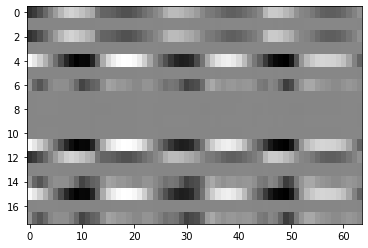

In [72]:
plt.imshow(Multi_train_feature_64[111],cmap = "gray",aspect="auto")

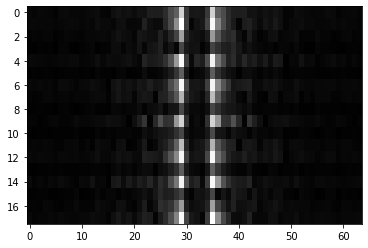

In [73]:
plt.imshow(Multi_train_64_AI[111],cmap = "gray",aspect="auto")

In [74]:
Multi_train_64_label[111]

'19'

## Save as npy

In [77]:
np.save('Multi_train_128_AI.npy', Multi_train_128_AI)
np.save('Multi_train_64_AI.npy', Multi_train_64_AI)
np.save('Multi_train_32_AI.npy', Multi_train_32_AI)

np.save('Multi_test_128_AI.npy', Multi_test_128_AI)
np.save('Multi_test_64_AI.npy', Multi_test_64_AI)
np.save('Multi_test_32_AI.npy', Multi_test_32_AI)

np.save('Multi_train_128_labels.npy', Multi_train_128_label_true)
np.save('Multi_train_64_labels.npy', Multi_train_64_label)
np.save('Multi_train_32_labels.npy', Multi_train_32_label)

np.save('Multi_test_128_labels.npy', Multi_test_128_label_true)
np.save('Multi_test_64_labels.npy', Multi_test_64_label)
np.save('Multi_test_32_labels.npy', Multi_test_32_label)

In [78]:
print(np.load('Multi_train_128_AI.npy').shape)
print(np.load('Multi_test_128_AI.npy').shape)
print(np.load('Multi_train_128_labels.npy',allow_pickle=True).shape)
print(np.load('Multi_test_128_labels.npy',allow_pickle=True).shape)

(2595, 18, 128)
(650, 18, 128)
(2595,)
(650,)


## Label:1-22

(1) right arm swipe to the left, 
(2) right arm swipe to the right, 
(3) right hand wave, 
(4) two hand front clap, 
(5) right arm throw, 
(6) cross arms in the chest, 
(7) basketball shoot, 
(8) right hand draw x, 
(9) right hand draw circle (clockwise), 
(10) right hand draw circle (counter clockwise), 
(11) draw triangle, 
(12) bowling (right hand), 
(13) front boxing, 
(14) baseball swing from right, 
(15) tennis right hand forehand swing, 
(16) arm curl (two arms), 
(17) tennis serve, 
(18) two hand push, 
(19) right hand knock on door, 
(20) right hand catch an object, 
(21) right hand pick up and throw

In [79]:
label_name = [
    'right arm swipe to the left', 
    'right arm swipe to the right', 
    'right hand wave', 
    'two hand front clap', 
    'right arm throw', 
    'cross arms in the chest', 
    'basketball shoot', 
    'right hand draw x', 
    'right hand draw circle (clockwise)', 
    'right hand draw circle (counter clockwise)', 
    'draw triangle', 
    'bowling (right hand)', 
    'front boxing', 
    'baseball swing from right', 
    'tennis right hand forehand swing', 
    'arm curl (two arms)', 
    'tennis serve', 
    'two hand push', 
    'right hand knock on door', 
    'right hand catch an object', 
    'right hand pick up and throw'
]